In [1]:
import ampal
import isambard
import isambard.specifications as specifications
import isambard.modelling as modelling
import isambard.optimisation as optimisation
import isambard.optimisation.evo_optimizers as ev_opts
from isambard.optimisation.evo_optimizers import Parameter
import budeff

import matplotlib.pyplot as plt
import numpy as np
import itertools
from pprint import pprint
import nglview as nv
from contextlib import redirect_stdout

%matplotlib inline

In [2]:
def show_ball_and_stick(ampal):
    view = nv.show_text(ampal.pdb)
    view.add_ball_and_stick()
    view.remove_cartoon()
    return view

In [3]:
class APHomoDimer(specifications.CoiledCoil):
    """Specification for creating anti-parallel, homodimeric coiled coils."""
    
    oligomeric_state = 2
    
    # The only thing that we need to define is a new `__init__` method, which defines
    # how the class is created. We get all the rest of the functionality off the
    # parent class `CoiledCoil`.
    def __init__(self, helix_length, radius, pitch, phica, zshift):
        # To kick everything off, this class runs the standard setup of the `CoiledCoil`
        # class, which gives our class all of the same attributes and methods. The
        # `super` function gives us access to the parent class. As we want to modify
        # some of the parameters before building the model, we set `auto_build` to false
        super().__init__(self.oligomeric_state, auto_build=False)
        
        # Next, we redefine the relevant default values that `CoiledCoil` has set. As
        # we have 2 helices, we have 2 values for each of these, but in this case they
        # are the same as we're making a homodimer
        self.aas = [helix_length, helix_length]
        self.major_radii = [radius, radius]
        self.major_pitches = [pitch, pitch]
        self.z_shifts = [0, zshift]
        self.phi_c_alphas = [phica, phica]
        
        # We need to set the orientation of the helices to be anti-parallel, so one
        # needs to have a +1 orientation and the other needs a -1 orientation
        self.orientations = [1, -1]

        # Now we've redefined these values, we need to build the model from these
        # parameters. We can do this using the build method, which comes from
        # `CoiledCoil`
        self.build()

In [4]:
REGISTER_ADJUST = {
    'a': 0,
    'b': 102.8,
    'c': 205.6,
    'd': 308.4,
    'e': 51.4,
    'f': 154.2,
    'g': 257
}

In [5]:
sequences = ['GQLEQELAALDQQIAALKQRRAALKWQIQG', 'GQLEQELAALDQQIAALKQRRAALKWQIQG']

In [6]:
def get_bude_total_energy(ampal_object):
    return budeff.get_internal_energy(ampal_object).total_energy

In [7]:
parameters = [
    optimisation.Parameter.static('Helix Length', 30),
    optimisation.Parameter.dynamic('Radius', 5.0, 1.0),
    optimisation.Parameter.dynamic('Pitch', 200, 60),
    optimisation.Parameter.dynamic('PhiCA', REGISTER_ADJUST['b'], 27),
    optimisation.Parameter.dynamic('ZShift', 10, 10),
]

In [8]:
default_values = [x.default_value for x in parameters]
print(default_values)

[30, 5.0, 200, 102.8, 10]


Genetic Algorithm

In [9]:
opt_ga = ev_opts.GA(APHomoDimer, sequences, parameters, get_bude_total_energy)

In [10]:
opt_ga.run_opt(100, 30, cores=8)

gen	evals	avg    	std    	min     	max     
0  	55   	-816.96	27.5318	-904.131	-765.242
1  	73   	-838.768	23.4082	-906.014	-806.001
2  	66   	-860.464	22.1181	-913.119	-829.325
3  	72   	-878.293	19.4847	-913.634	-850.295
4  	71   	-893.094	17.0313	-924.144	-864.813
5  	86   	-905.696	11.6678	-925.577	-879.051
6  	65   	-913.483	5.98835	-931.459	-903.58 
7  	62   	-916.883	5.40186	-931.459	-908.094
8  	64   	-920.466	4.9603 	-932.459	-912.716
9  	65   	-923.485	4.60416	-940.145	-916.488
10 	73   	-927.268	5.14743	-940.145	-920.902
11 	73   	-932.116	4.72197	-940.145	-924.22 
12 	67   	-936.592	2.49795	-940.185	-930.866
13 	72   	-938.841	1.08372	-943.66 	-936.703
14 	65   	-939.743	1.27293	-944.255	-937.905
15 	78   	-940.878	1.39043	-944.255	-939.097
16 	58   	-941.777	1.3993 	-944.255	-939.682
17 	64   	-942.507	1.27108	-945.899	-940.152
18 	79   	-943.584	0.758413	-946.211	-941.888
19 	57   	-944.046	0.569452	-946.211	-943.186
20 	70   	-944.531	0.600754	-946.68 	-943.748
21 	62   

In [11]:
optimized_model_ga = opt_ga.best_model

In [12]:
budeff.get_internal_energy(optimized_model_ga).total_energy

-946.9926748752645

In [13]:
funnel_data_ga = opt_ga.make_energy_funnel_data()

In [14]:
xs = [x[0] for x in funnel_data_ga]
ys = [x[1] for x in funnel_data_ga]
zs = [x[2] for x in funnel_data_ga]

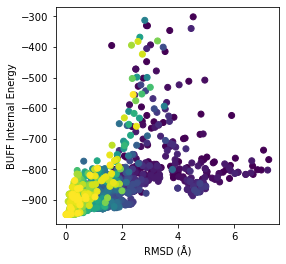

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('ga.png')

In [16]:
f = open('d_apCC-Di_new-optimized-model-ga.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_ga.pdb)

Differential Evolution

In [17]:
opt_de = ev_opts.DE(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [18]:
opt_de.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-808.072	59.3225	-920.067	-481.755
1  	100  	-831.305	33.5627	-925.61 	-730.69 
2  	100  	-843.529	32.6336	-929.422	-782.307
3  	100  	-851.7  	31.5739	-932.081	-804.278
4  	100  	-860.835	31.445 	-933.091	-804.278
5  	100  	-872.444	29.7457	-933.937	-812.106
6  	100  	-883.544	29.0848	-938.179	-812.106
7  	100  	-893.562	25.776 	-946.848	-848.461
8  	100  	-902.385	22.0992	-946.848	-848.461
9  	100  	-910.159	19.7652	-946.848	-848.461
10 	100  	-917.65 	16.7103	-946.848	-863.09 
11 	100  	-923.405	13.0171	-946.848	-875.223
12 	100  	-928.121	9.70692	-946.848	-899.846
13 	100  	-931.42 	8.30995	-946.984	-908.028
14 	100  	-934.575	7.12619	-947.347	-917.943
15 	100  	-937.186	6.52347	-948.669	-919.01 
16 	100  	-939.144	6.09464	-949.287	-922.595
17 	100  	-940.86 	5.01603	-949.287	-926.773
18 	100  	-942.563	4.3222 	-950.144	-926.773
19 	100  	-944.021	3.41361	-950.45 	-934.762
20 	100  	-945.541	2.71118	-950.45 	-937.493
21 	100  	

In [19]:
optimized_model_de = opt_de.best_model
budeff.get_internal_energy(optimized_model_de).total_energy

-951.618362880747

In [20]:
funnel_data_de = opt_de.make_energy_funnel_data()

In [21]:
xs = [x[0] for x in funnel_data_de]
ys = [x[1] for x in funnel_data_de]
zs = [x[2] for x in funnel_data_de]

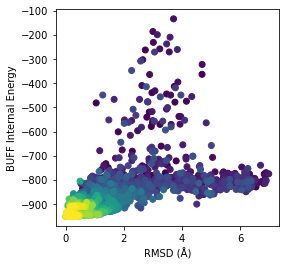

In [22]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('de.png')

In [23]:
f = open('d_apCC-Di_new-optimized-model-de.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_de.pdb)

Particle Swarm Optimisation

In [24]:
opt_pso = ev_opts.PSO(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [25]:
opt_pso.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-756.986	160.223	-910.649	-40.6553
1  	92   	-771.106	146.37 	-905.915	-40.6553
2  	91   	-789.159	110.175	-928.507	-349.593
3  	98   	-753.943	148.997	-931.84 	-204.053
4  	92   	-775.108	135.04 	-928.108	-204.053
5  	86   	-808.873	95.7039	-938.61 	-398.626
6  	84   	-725.663	178.189	-925.236	66.4104 
7  	89   	-729.273	169.182	-911.233	66.4104 
8  	96   	-781.311	119.02 	-915.347	-275.127
9  	92   	-757.491	151.304	-927.377	-168.137
10 	91   	-720.528	161.813	-902.97 	-168.137
11 	93   	-772.795	110.476	-913.239	-168.137
12 	93   	-740.302	143.338	-923.585	-168.137
13 	91   	-747.751	153.543	-928.945	-207.063
14 	89   	-707.797	153.836	-907.296	-207.063
15 	82   	-751.57 	144.567	-907.296	-49.9134
16 	59   	-804.624	110.729	-927.125	-49.9134
17 	62   	-756.472	160.615	-927.125	-49.9134
18 	81   	-770.445	118.516	-927.125	-213.32 
19 	95   	-804.125	105.912	-927.164	-304.302
20 	91   	-806.229	80.87  	-911.338	-376.524
21 	75   	

In [26]:
optimized_model_pso = opt_pso.best_model
budeff.get_internal_energy(optimized_model_pso).total_energy

-938.6095782950828

In [27]:
funnel_data_pso = opt_pso.make_energy_funnel_data()

In [28]:
xs = [x[0] for x in funnel_data_pso]
ys = [x[1] for x in funnel_data_pso]
zs = [x[2] for x in funnel_data_pso]

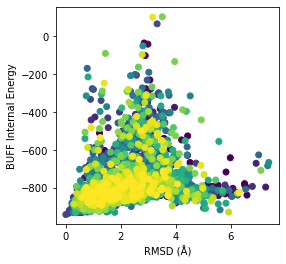

In [29]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('pso.png')

In [30]:
f = open('d_apCC-Di_new-optimized-model-pso.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_pso.pdb)

Covariance Matrix Adaptive Evolutionary Strategy

In [31]:
opt_cmaes = ev_opts.CMAES(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [32]:
opt_cmaes.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-783.688	94.6728	-923.412	-246.632
1  	100  	-811.252	54.3918	-922.908	-564.092
2  	100  	-821.18 	87.1947	-921.409	-256.958
3  	100  	-834.565	65.3112	-925.754	-542.201
4  	100  	-861.501	38.143 	-936.378	-743.296
5  	100  	-882.891	30.9506	-940.889	-810.203
6  	100  	-892.658	30.4727	-945.556	-771.301
7  	100  	-910.795	23.7341	-943.817	-838.211
8  	100  	-913.093	23.4948	-948.08 	-848.195
9  	100  	-926.986	16.7121	-948.005	-867.887
10 	100  	-925.173	19.2682	-947.684	-868.51 
11 	100  	-931.43 	18.1862	-949.648	-870.457
12 	100  	-935.722	16.3688	-950.827	-881.809
13 	100  	-934.334	19.3189	-950.437	-881.485
14 	100  	-938.121	16.8829	-950.723	-889.071
15 	100  	-938.082	19.0906	-951.833	-888.449
16 	100  	-939.978	17.1601	-952.746	-889.846
17 	100  	-938.613	19.0382	-952.383	-888.734
18 	100  	-936.075	20.9221	-952.609	-887.529
19 	100  	-935.26 	20.5308	-953.536	-890.058
20 	100  	-939.551	17.443 	-952.489	-890.429
21 	100  	

In [33]:
optimized_model_cmaes = opt_cmaes.best_model
budeff.get_internal_energy(optimized_model_cmaes).total_energy

-953.5364442529867

In [34]:
funnel_data_cmaes = opt_cmaes.make_energy_funnel_data()

In [35]:
xs = [x[0] for x in funnel_data_cmaes]
ys = [x[1] for x in funnel_data_cmaes]
zs = [x[2] for x in funnel_data_cmaes]

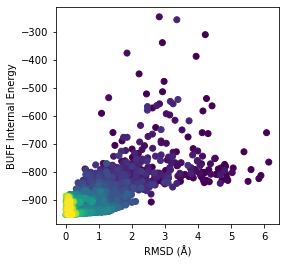

In [36]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('cmaes.png')

In [37]:
f = open('d_apCC-Di_new-optimized-model-cmaes.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_cmaes.pdb)